# Part 1: Stitching pairs of images

In [1]:
# imports
import numpy as np
import skimage
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 

In [2]:
# Provided code - nothing to change here

"""
Harris Corner Detector
Usage: Call the function harris(filename) for corner detection
Reference   (Code adapted from):
             http://www.kaij.org/blog/?p=89
             Kai Jiang - Harris Corner Detector in Python
             
"""
from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image

def harris(filename, min_distance = 10, threshold = 0.1):
    """
    filename: Path of image file
    threshold: (optional)Threshold for corner detection
    min_distance : (optional)Minimum number of pixels separating 
     corners and image boundary
    """
    im = np.array(Image.open(filename).convert("L"))
    harrisim = compute_harris_response(im)
    filtered_coords = get_harris_points(harrisim,min_distance, threshold)
    plot_harris_points(im, filtered_coords)
    return filtered_coords

def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]
    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

def gauss_kernel(size, sizey = None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def compute_harris_response(im):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    #derivatives
    gx,gy = gauss_derivative_kernels(3)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    #kernel for blurring
    gauss = gauss_kernel(3)
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')   
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy   
    return Wdet / Wtr

def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    axis('off')
    show()

# Usage: 
#harris('./path/to/image.jpg')

In [3]:
# Provided code - nothing to change here

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)

(4407, 128)


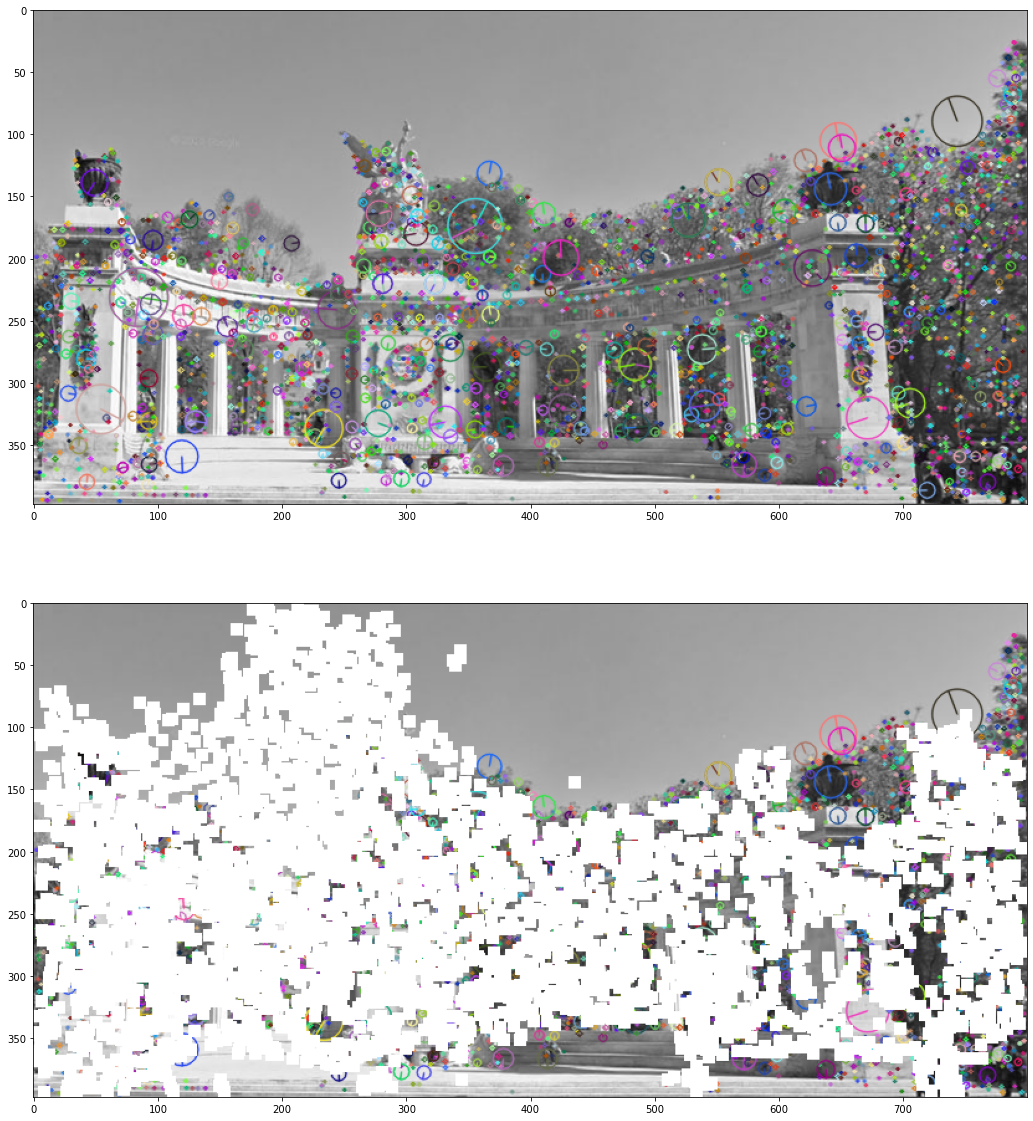

In [62]:
# See assignment page for the instructions!
import numpy.linalg as la
left = cv2.imread("left.jpg", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("right.jpg",cv2.IMREAD_GRAYSCALE)
sift = cv2.xfeatures2d.SIFT_create()
keypoints_right, descriptors_right = sift.detectAndCompute(right, None)
keypoints_left, descriptors_left = sift.detectAndCompute(left, None)
img=cv2.drawKeypoints(right, keypoints_right, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(211)
ax1.imshow(img)
print(descriptors_left.shape)
img_test = img.copy()
for i in range(len(keypoints_left)):
    a,b = keypoints_left[i].pt
    a = int(a)
    b = int(b)

    img_test[b-5:b+5, a-5:a+5] = 255
ax2 = plt.subplot(212)
ax2.imshow(img_test)


match descriptors to get candidates

In [6]:
descriptors_dist = scipy.spatial.distance.cdist(descriptors_left, descriptors_right, 'sqeuclidean')
dist_threshold = np.percentile(descriptors_dist, 0.005)
descriptors_dist_selected = np.where(descriptors_dist<dist_threshold, 1, 0)
matched_indices = []
points = set()
for i in range(descriptors_dist.shape[0]):
    for j in range(descriptors_dist.shape[1]):
        if descriptors_dist_selected[i,j] == 1:
            if (keypoints_left[i].pt, keypoints_right[j].pt) not in points:
                matched_indices.append([i,j])
                points.add((keypoints_left[i].pt, keypoints_right[j].pt))

matched_indices = np.array(matched_indices, dtype=int)
print(matched_indices.shape)

(733, 2)


convert to homogeneous np array

In [7]:

keypoints_left_pix = np.ones((len(keypoints_left), 3))
keypoints_right_pix = np.ones((len(keypoints_right), 3))
for i in range(len(keypoints_left)):
    keypoints_left_pix[i,:2] = np.array(keypoints_left[i].pt)
    keypoints_left_pix = np.rint(keypoints_left_pix)
    keypoints_left_pix = np.array(keypoints_left_pix, dtype=int)
for i in range(len(keypoints_right)):
    keypoints_right_pix[i,:2] = np.array(keypoints_right[i].pt)
    keypoints_right_pix = np.rint(keypoints_right_pix)
    keypoints_right_pix = np.array(keypoints_right_pix, dtype=int)

keypoints_left_matched = keypoints_left_pix[matched_indices[:,0]]
keypoints_right_matched = keypoints_right_pix[matched_indices[:,1]]

print(keypoints_left_matched.shape)

(733, 3)


visualize the candidate matched keypoints

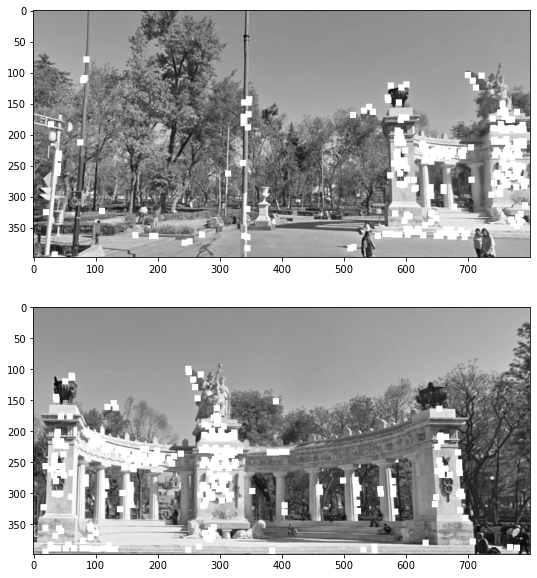

In [8]:
right_test = right.copy()
left_test = left.copy()
fig = plt.figure(figsize=(10,10))
for i in range(keypoints_left_matched.shape[0]):
    left_test[keypoints_left_matched[i,1]-5:keypoints_left_matched[i,1]+5, keypoints_left_matched[i,0]-5:keypoints_left_matched[i,0]+5] = 255
for i in range(keypoints_right_matched.shape[0]):
    right_test[keypoints_right_matched[i,1]-5:keypoints_right_matched[i,1]+5, keypoints_right_matched[i,0]-5:keypoints_right_matched[i,0]+5] = 255
ax1 = plt.subplot(211)
ax1.imshow(left_test, cmap='gray')
ax2 = plt.subplot(212)
ax2.imshow(right_test, cmap='gray')

compute homography

In [39]:
sample_size = 5
rhs = np.zeros(2 * sample_size)
n = matched_indices.shape[0]
H_optim = np.zeros((3,3))
max_inliers = -1
for i in range(500000):
    A = np.zeros((sample_size *2, 9))
    rand_indices = np.random.choice(n, sample_size)
    keypoints_right_rand = keypoints_right_matched[rand_indices]
    keypoints_left_rand = keypoints_left_matched[rand_indices]
    for j in range(sample_size):
        ind = j * 2
        A[ind,:3] = 0
        A[ind, 3:6] = keypoints_right_rand[j]
        A[ind, 6:] = -1 * keypoints_left_rand[j,1] * keypoints_right_rand[j]

        ind = j * 2 + 1
        A[ind,:3] = keypoints_right_rand[j]
        A[ind, 3:6] = 0
        A[ind, 6:] = -1 * keypoints_left_rand[j,0] * keypoints_right_rand[j]
    U, s, Vt = la.svd(A)
    h = Vt[-1]
    
    H = h.reshape((3,3))
    estimated_points = H @ keypoints_right_matched.T
    estimated_points = estimated_points.T
    estimated_points = estimated_points / estimated_points[:,2].reshape((-1,1))
    dist = la.norm(estimated_points - keypoints_left_matched, axis=1)
    num_inliers = np.sum(np.where(dist<5, 1,0))
    if num_inliers > max_inliers:
        max_inliers = num_inliers
        H_optim = H
print(max_inliers)


115


In [46]:
estimated_points = H_optim @ keypoints_right_matched.T
estimated_points = estimated_points.T
estimated_points = estimated_points / estimated_points[:,2].reshape((-1,1))
dist = la.norm(estimated_points - keypoints_left_matched, axis=1)
dist = dist[dist<5]
print(np.mean(dist))

1.8581670478756518


visualize homogeneous inliers

(115, 4)


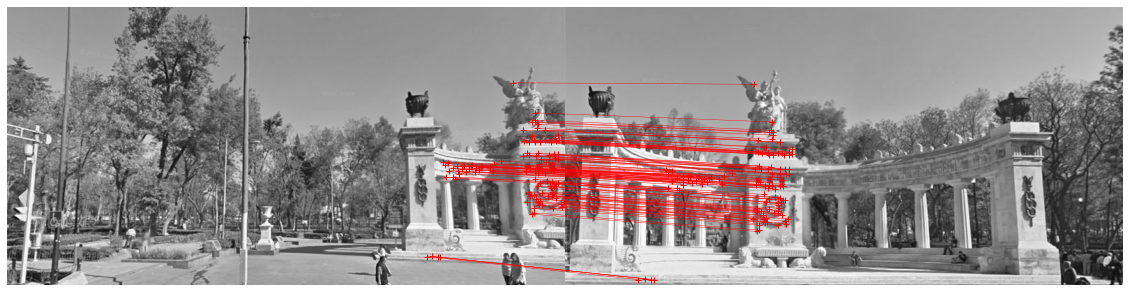

In [40]:
estimated_points = H_optim @ keypoints_right_matched.T
estimated_points = estimated_points.T
estimated_points = estimated_points/estimated_points[:,2].reshape((-1,1))
dist = la.norm(estimated_points - keypoints_left_matched, axis=1)

inliers_right = keypoints_right_matched[dist<5]
inliers_left = estimated_points[dist<5]

inliers = np.concatenate((inliers_left[:,:2], inliers_right[:,:2]),axis=1)
print(inliers.shape)
fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(111)
plot_inlier_matches(ax1, left, right, inliers)


visualize transformed image

(398, 800, 3)


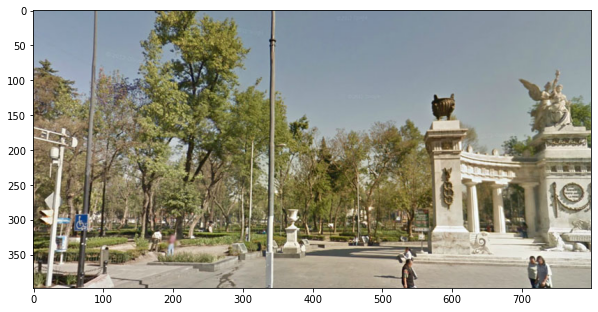

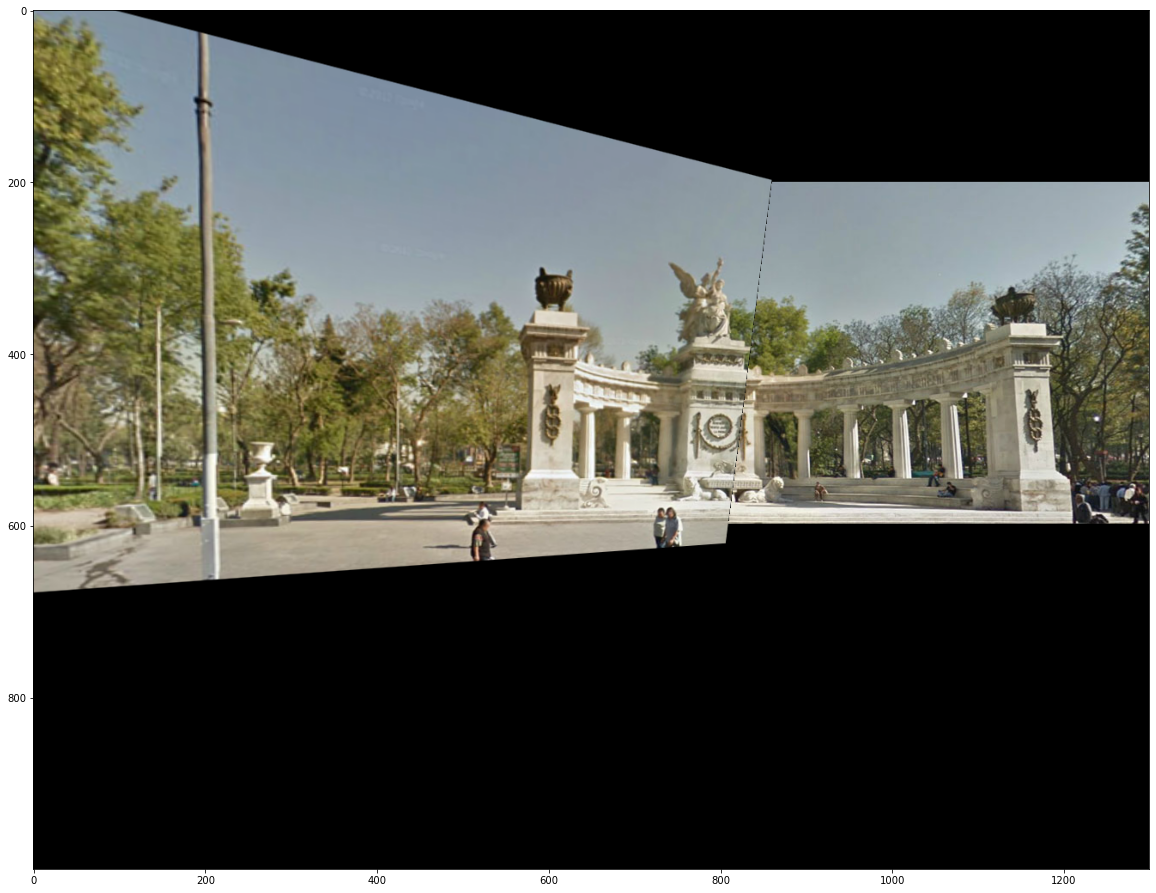

In [70]:
import skimage.transform
translation = np.array([[1,0,-500],[0,1,-200],[0,0,1]])
identity = np.array([[1,0,0],[0,1,0],[0,0,1]])
fig = plt.figure(figsize=(10,10))
projectiveTransform = skimage.transform.ProjectiveTransform(H_optim @ translation)
identityTransform = skimage.transform.ProjectiveTransform(identity)
translationTransform = skimage.transform.ProjectiveTransform(translation)

left = cv2.imread("left.jpg")
right = cv2.imread("right.jpg")
print(left.shape)

result = np.zeros((1000,1300,3))
for i in range(3):
    alligned_img = skimage.transform.warp(left[:,:,i], projectiveTransform, output_shape=(1000,1300))
    pivot_img = skimage.transform.warp(right[:,:,i], translationTransform , output_shape=(1000,1300))

    sum_img = alligned_img + pivot_img
    product_img = pivot_img * alligned_img
    result_slice = np.where(product_img==0, sum_img, alligned_img)
    result[:,:,i] = result_slice
plt.imshow(cv2.cvtColor(left, cv2.COLOR_BGR2RGB))
result = result * 255
result = result.astype("uint8")
figure = plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

Visualize alligned image